In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import transformations as t
from mpl_toolkits.mplot3d import Axes3D
import os

tf.logging.set_verbosity(tf.logging.INFO)

def show_cv2(img):
    # swap b and r channels
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])

    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.show()

def plot_histogram(img):
    color = ('b','g','r')
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(histr,color = col)
        plt.xlim([0,256])
    plt.show()
    
def add_grayscale_noise(img, std_dev):
    noise = np.expand_dims(np.random.normal(0, std_dev, size=img.shape[:2]).astype(np.int8), axis=2)
    img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return img

def add_colored_noise(img, std_dev):
    noise = np.random.normal(0, std_dev, size=img.shape).astype(np.int8)
    img = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return img



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def listfiles(path):
    return [os.path.join(dp, f) for dp, dn, fn in os.walk(path) for f in fn]
tag_urls = listfiles("./tags")
scene_urls = listfiles("./places")

print(tag_urls[0], scene_urls[0])

./tags/tag36_11_00142.png ./places/Places365_val_00013979.jpg


In [3]:
# Populate some camera intrinsic settings
# And other constants
# To do: capitolize these variables names idk how to find and replace in this notebook

camera_intrinsics = [1.1998640834468974e+03, 0, 640.0 / 2, 0, 1.1998640834468974e+03, 480.0 / 2, 0, 0, 1]
camera_intrinsics = np.array(camera_intrinsics).reshape([3, 3])

fx = camera_intrinsics[0,0]
fy = camera_intrinsics[1,1]
cx = camera_intrinsics[0,2]
cy = camera_intrinsics[1,2]

tag_size = 0.01

print(camera_intrinsics)

[[1.19986408e+03 0.00000000e+00 3.20000000e+02]
 [0.00000000e+00 1.19986408e+03 2.40000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [4]:
def gen_sample(noise_background=False, plot=False):
    if noise_background:
        img_scene = np.random.randint(0, 255, size=(480, 640, 3)).astype(np.uint8)
    else:
        img_scene = cv2.resize(cv2.imread(np.random.choice(scene_urls)), (640, 480), interpolation=cv2.INTER_AREA)

    img_tag = cv2.resize(cv2.imread(np.random.choice(tag_urls)), (200, 200), interpolation=cv2.INTER_NEAREST)

    world_corners = np.array([[-1, -1], [1, -1], [-1, 1], [1, 1]]) * tag_size / 2.0
    pixel_corners = np.array([[0, 0], [1, 0], [0, 1], [1, 1]]) * np.array(img_tag.shape)[:2]

    # Add a Z component and homogeneous coordinate
    corners_3d = np.hstack((world_corners, np.array([[0, 1]] * 4)))
    
    
    done = False
    attempts = 0
    while not done:
        # Apply a random rotation to our corners
        angle_lim = np.pi / 2.5
        x_rot = np.random.uniform(-angle_lim, angle_lim)
        rotation_matrix = t.rotation_matrix(np.random.uniform(-angle_lim, angle_lim), [1, 0, 0])
        rotation_matrix = rotation_matrix @ t.rotation_matrix(np.random.uniform(-angle_lim, angle_lim), [0, 1, 0])
        rotation_matrix = rotation_matrix @ t.rotation_matrix(np.random.uniform(-np.pi, np.pi), [0, 0, 1])
        corners_3d_rotated = (rotation_matrix @ corners_3d.T).T

        # Translate our corners to a random 3D point within our camera view
        z = np.random.triangular(0.05, 0.05, 0.2)
        x = np.random.uniform(-1, 1) * z / fx * cx
        y = np.random.uniform(-1, 1) * z / fy * cy
        translation = np.array([x, y, z])
        translation_matrix = t.translation_matrix(translation)
        corners_3d_transformed = (translation_matrix @ corners_3d_rotated.T).T

        # Project into 2D image space
        projected_transformed = camera_intrinsics @ corners_3d_transformed.T[:3]
        projected_transformed /= projected_transformed[2]

        projected_transformed = np.vstack((projected_transformed[0], projected_transformed[1]))
        # print(projected_transformed)

        done = True
        attempts += 1
        for (x, y) in projected_transformed.T:
            # Reject views that have tag corners chopped off
            if x < 0 or y < 0 or x > cx * 2 or y > cy * 2:
                done = False

    # print(attempts, "attempt(s)")

    # Compute a homography
    H = cv2.findHomography(pixel_corners, projected_transformed.T)[0]

    # Random lighting condition
    dynamic_range = np.random.uniform(0.9, 1.0)
    img_tag_lighting = img_tag * dynamic_range
    img_tag_lighting += (1.0 - dynamic_range) * np.random.uniform(0, 255)
    img_tag_lighting = img_tag_lighting.astype(np.uint8)
    
    # Some noise
    img_tag_filtered = cv2.GaussianBlur(img_tag_lighting, (9, 9), 0)
    img_tag_filtered = add_colored_noise(img_tag_filtered, 4)
    img_tag_filtered = add_grayscale_noise(img_tag_filtered, 10)
    
    # Overlay warped image
    img_scene_with_tag = np.array(img_scene)
    cv2.warpPerspective(img_tag_filtered, H, dsize=img_scene.shape[:2][::-1], dst=img_scene_with_tag, borderMode=cv2.BORDER_TRANSPARENT)
    img_scene_with_tag = cv2.GaussianBlur(img_scene_with_tag, (3, 3), 0)
    img_scene = cv2.GaussianBlur(img_scene, (3, 3), 0)

    # Bias our tag's color towards the image average color
    img_tag_filtered = (img_tag_filtered * 49.0 / 50.0 + (np.mean(img_scene,axis=(0,1)) / 50.0).astype(np.int16)).astype(np.uint8)

    # Plot?
    if plot:
        show_cv2(img_tag_filtered)
        
        # Visualize in 3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        xs = corners_3d.T[0]
        ys = corners_3d.T[1]
        zs = corners_3d.T[2]
        ax.scatter(xs, ys, zs)

        xs = corners_3d_transformed.T[0]
        ys = corners_3d_transformed.T[1]
        zs = corners_3d_transformed.T[2]
        ax.scatter(xs, ys, zs)

        # Visualize in 3D
        plt.figure()
        plt.ylim(0, cy * 2)
        plt.xlim(0, cx * 2)

        #xs = projected_orig[0]
        #ys = projected_orig[1]
        #plt.scatter(xs, ys)
        xs = projected_transformed[0]
        ys = projected_transformed[1]
        plt.plot(xs, ys)

        plt.show()
        
        # Visualize the scene + histograms
        plot_histogram(img_scene)
        show_cv2(img_scene)

        plot_histogram(img_scene_with_tag)
        show_cv2(img_scene_with_tag)

    return img_scene, img_scene_with_tag, corners_3d_transformed

# gen_sample(False, True)
# pass

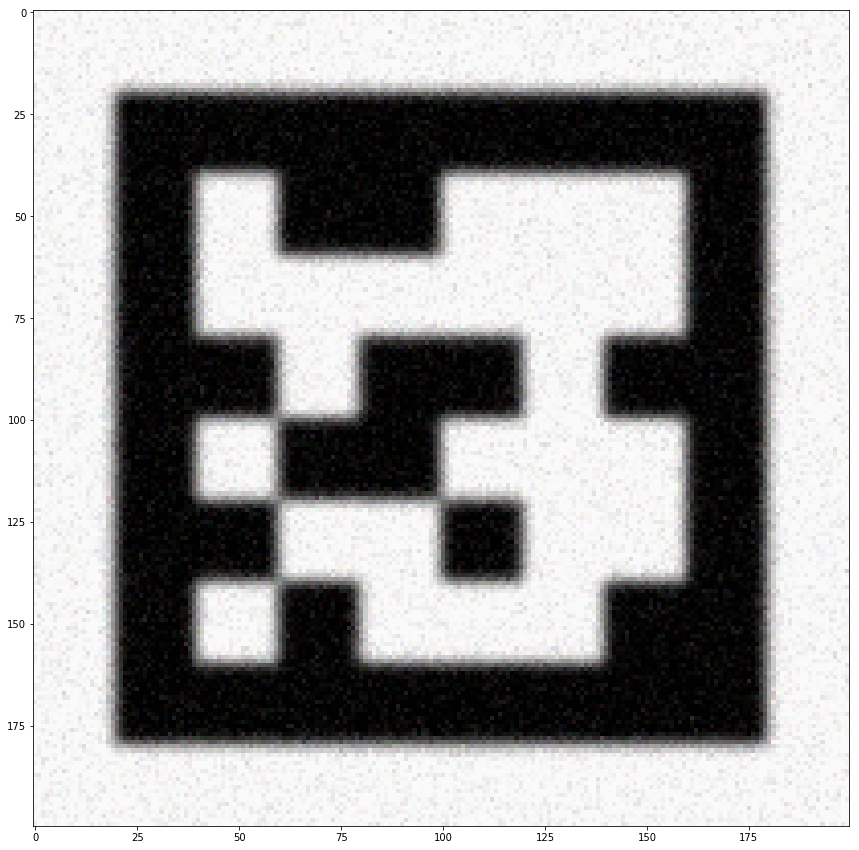

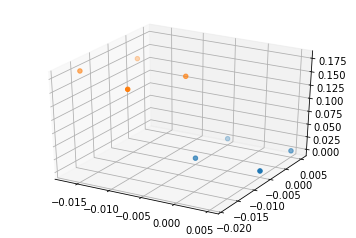

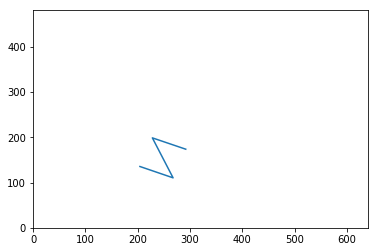

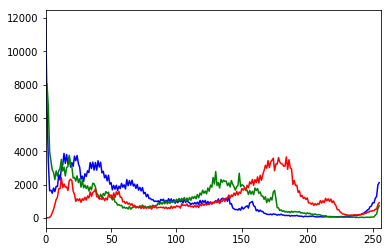

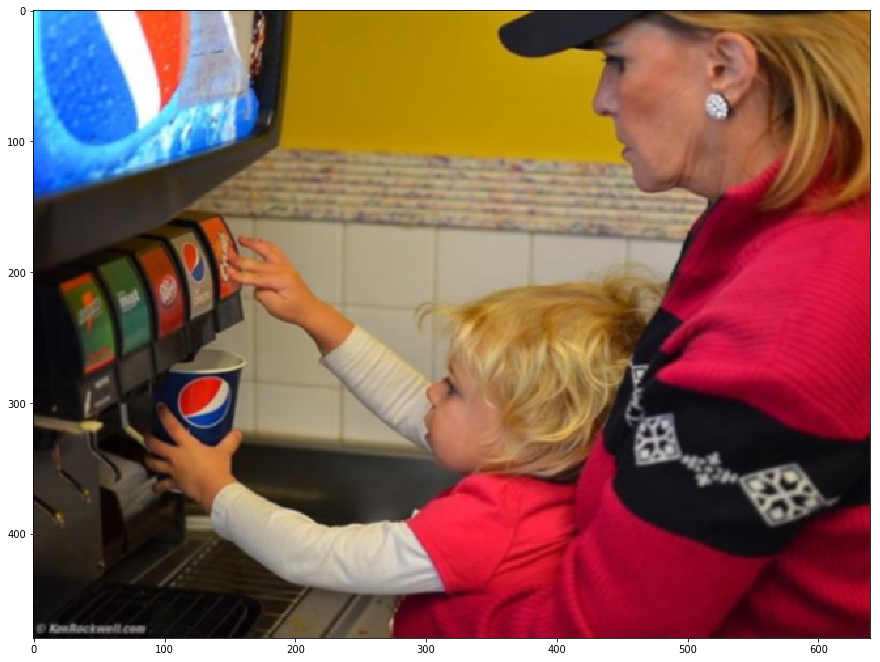

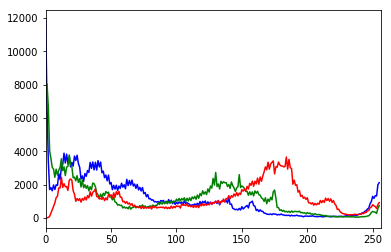

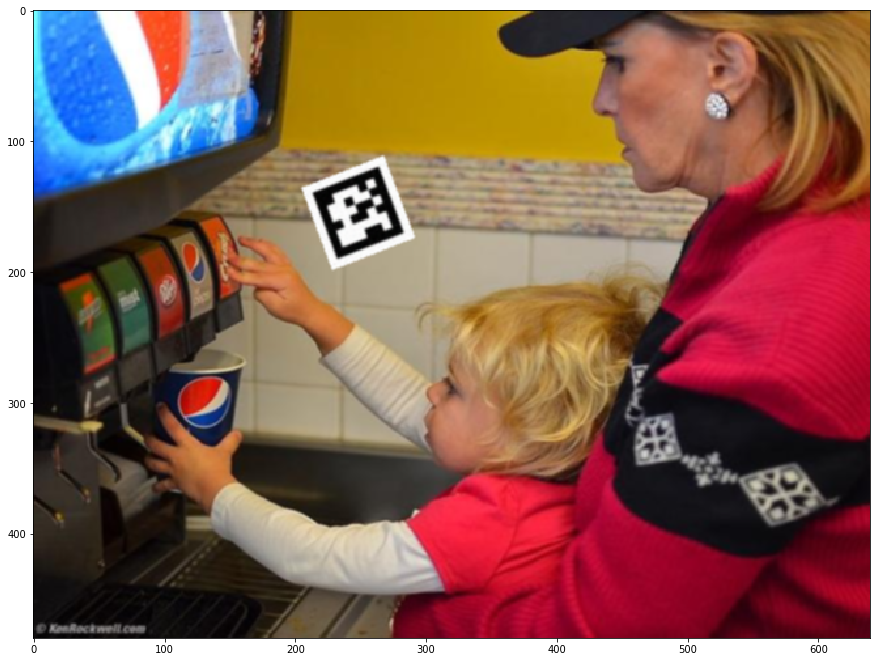

In [5]:
# Test for generating training sample

gen_sample(False, True)
pass

In [6]:
global global_scene

# Helper for generating training/validation batches

def gen_samples(n, noise_scene=False, plot=False, include_neg=False):
    images = []
    labels = []
    for _ in range(n):
        neg, pos, transform = gen_sample(noise_scene, plot)
        
        global global_scene
        global_scene = pos

        neg = neg.astype(np.float32)
        pos = pos.astype(np.float32)
        neg /= 255.0
        neg -= 0.5
        pos /= 255.0
        pos -= 0.5

        if include_neg:
            images.append(neg)
            labels.append(0)
            
        images.append(pos)
        labels.append(transform)
        
    return np.asarray(images), np.asarray(labels).astype(np.float32)

In [7]:
def cnn_model_fn(features, labels, mode):

    """Model function for CNN."""
    # Input Layer
    
    #######################################################33
    # TODO: fill in size
    size = [480, 640]
    
    input_layer = tf.image.resize_images(
                            features["x"],
                            size,
                            method=tf.image.ResizeMethod.BILINEAR,
                            align_corners=False)

    ### TODO: make these stride size smaller when we have more than 2 hours to train this model
    print("features", features["x"].shape)
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.leaky_relu)
    
    conv1_1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.tanh)
    
    print("conv1", tf.concat([conv1, conv1_1], axis=1).shape)
#     pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[4, 5], strides=4)
    pool1 = tf.layers.max_pooling2d(inputs=tf.concat([conv1, conv1_1], axis=1), pool_size=[4, 5], strides=4)

    print("pool1", pool1.shape)
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.leaky_relu)
    
    print("conv2", conv2.shape)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[9, 4], strides=4)
    print("pool2", pool2.shape)
    
    
    pool2 = tf.layers.dropout(inputs=pool2, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    # Convolutional Layer #3 and Pooling Layer #3
    conv3 = tf.layers.conv2d(
      inputs=pool2,
      filters=16,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.leaky_relu)
    print("conv3", conv3.shape)
    
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[7, 5], strides=[13, 9])
    print("pool3", pool3.shape)
    
    conv4 = tf.layers.conv2d(
        inputs=pool3,
        filters=1,
        kernel_size=[8, 6],
        padding="same",
        activation=tf.nn.sigmoid)
    print("conv4", conv4.shape)
    
    dropout = tf.layers.dropout(inputs=conv4, rate=0.5, training=mode == tf.estimator.ModeKeys.TRAIN)
    print("dropout", dropout.shape)
    
    
    prob = tf.squeeze(dropout, -1, name="prob_tensor")
    print("probabilities", prob.shape)
    
    labels = tf.convert_to_tensor(labels, dtype=tf.float32, name="label_tensor")
    labels = tf.add(labels, tf.constant(0.0), name="label_tensor")
    print("label", labels.shape)
    
    predictions = {
      "predictions": tf.round(prob),
      "probabilities": prob
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return prob

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.nn.l2_loss(labels - prob, name="loss")
    print(loss)

    # Add a margin to the lossf
    # loss = tf.maximum(tf.constant(0.0), loss - 0.0004)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    
    # Saliency
    
    accuracy = tf.metrics.accuracy(
          labels=labels, predictions=predictions["predictions"], name="accuracy")
    
    saliency_grad = tf.gradients(prob, input_layer, name="saliency_grad")
    saliency_map = tf.squeeze(tf.reduce_max(tf.abs(saliency_grad), axis=4), name="saliency_map")

    eval_metric_ops = {"accuracy": accuracy}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [9]:
print("Building estimator...", flush=True)
# Create the Estimator
classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="./transform_model")

def train():
    #######################################################
    # TODO NEED TO FIX THE ENTIRE FUNCTION

    # Set up logging for predictions
    tensors_to_log = {"loss": "loss", "prob": "prob_tensor", "labels": "label_tensor"}
    logging_hook = tf.train.LoggingTensorHook(
      tensors=tensors_to_log, every_n_iter=100)

    print("Training model...", flush=True)
    # Train the model
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_data},
      y=train_labels,
      batch_size=20,
      num_epochs=None,
      shuffle=True)

    classifier.train(
      input_fn=train_input_fn,
      steps=4)
# train()

def eval():
    print("Evaluating model...", flush=True)
    # Evaluate the model and print results
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": eval_data},
      y=eval_labels,
      num_epochs=1,
      shuffle=False)
    saliency_hook = SaliencyHook()
    eval_results = classifier.evaluate(input_fn=eval_input_fn, hooks=[saliency_hook])
    print(eval_results)

    
    
for i in range(500):
    train_data, train_labels = gen_samples(50, False)
    train()


Building estimator...


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_master': '', '_global_id_in_cluster': 0, '_save_summary_steps': 100, '_service': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_task_type': 'worker', '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_num_worker_replicas': 1, '_tf_random_seed': None, '_log_step_count_steps': 100, '_is_chief': True, '_num_ps_replicas': 0, '_task_id': 0, '_model_dir': './transform_model', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f6d4d0d6470>, '_evaluation_master': ''}


Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-180
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 181 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 24.847294, step = 180
INFO:tensorflow:Saving checkpoints for 184 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.316654.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-184
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 185 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.404137, step = 184
INFO:tensorflow:Saving checkpoints for 188 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.820276.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-188
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 189 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.261904, step = 188
INFO:tensorflow:Saving checkpoints for 192 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.285564.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-192
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 193 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.765139, step = 192
INFO:tensorflow:Saving checkpoints for 196 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.807838.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-196
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 197 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.753138, step = 196
INFO:tensorflow:Saving checkpoints for 200 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.330801.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 201 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.291737, step = 200
INFO:tensorflow:Saving checkpoints for 204 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.919146.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-204
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 205 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.354572, step = 204
INFO:tensorflow:Saving checkpoints for 208 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.318174.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-208
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 209 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.368122, step = 208
INFO:tensorflow:Saving checkpoints for 212 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.873894.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-212
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 213 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.34012, step = 212
INFO:tensorflow:Saving checkpoints for 216 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.849247.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-216
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 217 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.376896, step = 216
INFO:tensorflow:Saving checkpoints for 220 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.82806.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-220
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 221 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.314222, step = 220
INFO:tensorflow:Saving checkpoints for 224 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.807735.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-224
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 225 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 27.366425, step = 224
INFO:tensorflow:Saving checkpoints for 228 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.877882.


 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-228
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 229 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.364185, step = 228
INFO:tensorflow:Saving checkpoints for 232 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.839863.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-232
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 233 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.209358, step = 232
INFO:tensorflow:Saving checkpoints for 236 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.721687.


 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-236
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 237 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 25.424822, step = 236
INFO:tensorflow:Saving checkpoints for 240 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.354342.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-240
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 241 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.33316, step = 240
INFO:tensorflow:Saving checkpoints for 244 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.261755.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-244
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 245 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 25.251598, step = 244
INFO:tensorflow:Saving checkpoints for 248 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 15.378653.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-248
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 249 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.35368, step = 248
INFO:tensorflow:Saving checkpoints for 252 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.860947.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-252
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 253 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.196972, step = 252
INFO:tensorflow:Saving checkpoints for 256 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.826832.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-256
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 257 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.903906, step = 256
INFO:tensorflow:Saving checkpoints for 260 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.402061.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-260
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 261 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.865726, step = 260
INFO:tensorflow:Saving checkpoints for 264 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.330997.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-264
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 265 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.83898, step = 264
INFO:tensorflow:Saving checkpoints for 268 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.821482.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-268
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 269 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.768024, step = 268
INFO:tensorflow:Saving checkpoints for 272 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 24.298908.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-272
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 273 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.274948, step = 272
INFO:tensorflow:Saving checkpoints for 276 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.86023.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-276
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 277 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 14.85293, step = 276
INFO:tensorflow:Saving checkpoints for 280 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.835096.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-280
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 281 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.872221, step = 280
INFO:tensorflow:Saving checkpoints for 284 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.764097.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-284
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 285 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.746643, step = 284
INFO:tensorflow:Saving checkpoints for 288 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.271336.


 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-288
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 289 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 25.859951, step = 288
INFO:tensorflow:Saving checkpoints for 292 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.175608.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-292
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 293 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.358164, step = 292
INFO:tensorflow:Saving checkpoints for 296 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.851175.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-296
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 297 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.323713, step = 296
INFO:tensorflow:Saving checkpoints for 300 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.831066.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 301 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.464748, step = 300
INFO:tensorflow:Saving checkpoints for 304 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.31318.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-304
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 305 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.810225, step = 304
INFO:tensorflow:Saving checkpoints for 308 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.767525.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-308
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 309 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.269802, step = 308
INFO:tensorflow:Saving checkpoints for 312 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.335245.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-312
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 313 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.818123, step = 312
INFO:tensorflow:Saving checkpoints for 316 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.768614.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-316
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 317 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.751791, step = 316
INFO:tensorflow:Saving checkpoints for 320 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.394234.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-320
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 321 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.816078, step = 320
INFO:tensorflow:Saving checkpoints for 324 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.845594.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-324
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 325 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.39372, step = 324
INFO:tensorflow:Saving checkpoints for 328 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.8665.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-328
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 329 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 24.312572, step = 328
INFO:tensorflow:Saving checkpoints for 332 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.370974.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-332
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 333 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.330147, step = 332
INFO:tensorflow:Saving checkpoints for 336 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.278719.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-336
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 337 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.865353, step = 336
INFO:tensorflow:Saving checkpoints for 340 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.986595.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-340
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 341 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.285, step = 340
INFO:tensorflow:Saving checkpoints for 344 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.714169.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-344
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 345 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.401535, step = 344
INFO:tensorflow:Saving checkpoints for 348 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.414032.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-348
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 349 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.260986, step = 348
INFO:tensorflow:Saving checkpoints for 352 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.280193.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-352
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 353 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.416985, step = 352
INFO:tensorflow:Saving checkpoints for 356 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.34648.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-356
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 357 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.848518, step = 356
INFO:tensorflow:Saving checkpoints for 360 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.336102.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-360
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 361 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.06773, step = 360
INFO:tensorflow:Saving checkpoints for 364 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.511383.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-364
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 365 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.863493, step = 364
INFO:tensorflow:Saving checkpoints for 368 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.796041.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-368
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 369 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 25.794905, step = 368
INFO:tensorflow:Saving checkpoints for 372 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.24435.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-372
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 373 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.798885, step = 372
INFO:tensorflow:Saving checkpoints for 376 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 15.7893095.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-376
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 377 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.26948, step = 376
INFO:tensorflow:Saving checkpoints for 380 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.24071.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-380
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 381 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 24.865051, step = 380
INFO:tensorflow:Saving checkpoints for 384 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.350384.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-384
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 385 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.835213, step = 384
INFO:tensorflow:Saving checkpoints for 388 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.888987.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-388
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 389 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.411634, step = 388
INFO:tensorflow:Saving checkpoints for 392 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.913855.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-392
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 393 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.900837, step = 392
INFO:tensorflow:Saving checkpoints for 396 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.213161.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-396
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 397 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 24.265915, step = 396
INFO:tensorflow:Saving checkpoints for 400 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 24.8236.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 401 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.336098, step = 400
INFO:tensorflow:Saving checkpoints for 404 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.738798.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-404
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 405 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.266613, step = 404
INFO:tensorflow:Saving checkpoints for 408 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.783897.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-408
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 409 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.355413, step = 408
INFO:tensorflow:Saving checkpoints for 412 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.41613.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-412
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 413 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.786184, step = 412
INFO:tensorflow:Saving checkpoints for 416 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.379091.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-416
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 417 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.76578, step = 416
INFO:tensorflow:Saving checkpoints for 420 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.808868.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-420
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 421 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.189842, step = 420
INFO:tensorflow:Saving checkpoints for 424 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 26.228611.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-424
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 425 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 15.789269, step = 424
INFO:tensorflow:Saving checkpoints for 428 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.377.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-428
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 429 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.233076, step = 428
INFO:tensorflow:Saving checkpoints for 432 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.357565.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-432
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 433 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.31953, step = 432
INFO:tensorflow:Saving checkpoints for 436 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.283688.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-436
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 437 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.328897, step = 436
INFO:tensorflow:Saving checkpoints for 440 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 25.232882.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-440
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 441 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.857832, step = 440
INFO:tensorflow:Saving checkpoints for 444 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.774754.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-444
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 445 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.263477, step = 444
INFO:tensorflow:Saving checkpoints for 448 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.84483.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-448
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 449 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.333757, step = 448
INFO:tensorflow:Saving checkpoints for 452 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.29132.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-452
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 453 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.229465, step = 452
INFO:tensorflow:Saving checkpoints for 456 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.268787.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-456
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 457 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.766384, step = 456
INFO:tensorflow:Saving checkpoints for 460 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.77577.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-460
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 461 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.800873, step = 460
INFO:tensorflow:Saving checkpoints for 464 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 14.78112.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-464
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 465 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.946562, step = 464
INFO:tensorflow:Saving checkpoints for 468 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.389706.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-468
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 469 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 24.26843, step = 468
INFO:tensorflow:Saving checkpoints for 472 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.34943.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-472
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 473 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.823082, step = 472
INFO:tensorflow:Saving checkpoints for 476 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.836206.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-476
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 477 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 15.7937565, step = 476
INFO:tensorflow:Saving checkpoints for 480 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.815546.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-480
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 481 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.85844, step = 480
INFO:tensorflow:Saving checkpoints for 484 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.913141.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-484
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 485 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.757814, step = 484
INFO:tensorflow:Saving checkpoints for 488 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.231909.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-488
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 489 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.387184, step = 488
INFO:tensorflow:Saving checkpoints for 492 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.286121.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-492
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 493 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.296791, step = 492
INFO:tensorflow:Saving checkpoints for 496 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.724918.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-496
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 497 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 24.324001, step = 496
INFO:tensorflow:Saving checkpoints for 500 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 26.329384.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 501 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.383566, step = 500
INFO:tensorflow:Saving checkpoints for 504 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.24048.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-504
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 505 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.776337, step = 504
INFO:tensorflow:Saving checkpoints for 508 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.388716.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-508
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 509 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.266987, step = 508
INFO:tensorflow:Saving checkpoints for 512 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.40325.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-512
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 513 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.326014, step = 512
INFO:tensorflow:Saving checkpoints for 516 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.317528.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-516
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 517 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.815132, step = 516
INFO:tensorflow:Saving checkpoints for 520 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.804447.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-520
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 521 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.3483, step = 520
INFO:tensorflow:Saving checkpoints for 524 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.840078.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-524
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 525 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.740742, step = 524
INFO:tensorflow:Saving checkpoints for 528 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.884775.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-528
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 529 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.35484, step = 528
INFO:tensorflow:Saving checkpoints for 532 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.296526.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-532
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 533 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.845722, step = 532
INFO:tensorflow:Saving checkpoints for 536 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 26.722584.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-536
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 537 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.215452, step = 536
INFO:tensorflow:Saving checkpoints for 540 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.739056.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-540
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 541 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 15.764754, step = 540
INFO:tensorflow:Saving checkpoints for 544 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.000746.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-544
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 545 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.74427, step = 544
INFO:tensorflow:Saving checkpoints for 548 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.778187.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-548
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 549 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.407806, step = 548
INFO:tensorflow:Saving checkpoints for 552 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.363121.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-552
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 553 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.800909, step = 552
INFO:tensorflow:Saving checkpoints for 556 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.850681.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-556
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 557 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.795397, step = 556
INFO:tensorflow:Saving checkpoints for 560 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.288744.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-560
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 561 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.287317, step = 560
INFO:tensorflow:Saving checkpoints for 564 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.840563.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-564
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 565 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.721653, step = 564
INFO:tensorflow:Saving checkpoints for 568 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.805094.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-568
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 569 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.799547, step = 568
INFO:tensorflow:Saving checkpoints for 572 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.82534.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-572
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 573 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.907913, step = 572
INFO:tensorflow:Saving checkpoints for 576 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.291996.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-576
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 577 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.849184, step = 576
INFO:tensorflow:Saving checkpoints for 580 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.86531.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-580
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 581 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.223583, step = 580
INFO:tensorflow:Saving checkpoints for 584 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.260866.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-584
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 585 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.316109, step = 584
INFO:tensorflow:Saving checkpoints for 588 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.794073.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-588
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 589 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.335308, step = 588
INFO:tensorflow:Saving checkpoints for 592 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.30072.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-592
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 593 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.796814, step = 592
INFO:tensorflow:Saving checkpoints for 596 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.326893.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-596
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 597 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.293118, step = 596
INFO:tensorflow:Saving checkpoints for 600 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.329361.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 601 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 15.761014, step = 600
INFO:tensorflow:Saving checkpoints for 604 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.905676.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-604
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 605 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.899857, step = 604
INFO:tensorflow:Saving checkpoints for 608 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 24.359135.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-608
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 609 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.8779, step = 608
INFO:tensorflow:Saving checkpoints for 612 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.356007.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-612
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 613 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.807814, step = 612
INFO:tensorflow:Saving checkpoints for 616 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.339746.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-616
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 617 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.295994, step = 616
INFO:tensorflow:Saving checkpoints for 620 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.223696.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-620
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 621 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.295448, step = 620
INFO:tensorflow:Saving checkpoints for 624 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.281805.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-624
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 625 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.366104, step = 624
INFO:tensorflow:Saving checkpoints for 628 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.278187.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-628
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 629 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.358622, step = 628
INFO:tensorflow:Saving checkpoints for 632 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.299747.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-632
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 633 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.308865, step = 632
INFO:tensorflow:Saving checkpoints for 636 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.88168.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-636
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 637 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.823904, step = 636
INFO:tensorflow:Saving checkpoints for 640 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.350052.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-640
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 641 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.784065, step = 640
INFO:tensorflow:Saving checkpoints for 644 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.466461.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-644
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 645 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.840866, step = 644
INFO:tensorflow:Saving checkpoints for 648 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 25.295252.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-648
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 649 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.324467, step = 648
INFO:tensorflow:Saving checkpoints for 652 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.80888.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-652
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 653 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 25.279644, step = 652
INFO:tensorflow:Saving checkpoints for 656 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.910217.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-656
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 657 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.875828, step = 656
INFO:tensorflow:Saving checkpoints for 660 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.248642.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-660
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 661 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.391695, step = 660
INFO:tensorflow:Saving checkpoints for 664 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.844355.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-664
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 665 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.750448, step = 664
INFO:tensorflow:Saving checkpoints for 668 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.216293.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-668
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 669 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.673172, step = 668
INFO:tensorflow:Saving checkpoints for 672 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.253967.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-672
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 673 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.79137, step = 672
INFO:tensorflow:Saving checkpoints for 676 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.361435.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-676
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 677 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.805605, step = 676
INFO:tensorflow:Saving checkpoints for 680 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.81039.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-680
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 681 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.364433, step = 680
INFO:tensorflow:Saving checkpoints for 684 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.77763.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-684
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 685 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.885155, step = 684
INFO:tensorflow:Saving checkpoints for 688 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.738504.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-688
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 689 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 24.36795, step = 688
INFO:tensorflow:Saving checkpoints for 692 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 15.254351.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-692
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 693 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.399801, step = 692
INFO:tensorflow:Saving checkpoints for 696 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.95501.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-696
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 697 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.87357, step = 696
INFO:tensorflow:Saving checkpoints for 700 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.855366.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-700
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 701 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.411896, step = 700
INFO:tensorflow:Saving checkpoints for 704 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.42869.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-704
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 705 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.312878, step = 704
INFO:tensorflow:Saving checkpoints for 708 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.756714.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-708
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 709 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.865328, step = 708
INFO:tensorflow:Saving checkpoints for 712 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.346151.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-712
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 713 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.183113, step = 712
INFO:tensorflow:Saving checkpoints for 716 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.857353.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-716
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 717 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.240002, step = 716
INFO:tensorflow:Saving checkpoints for 720 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.838964.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-720
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 721 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.938524, step = 720
INFO:tensorflow:Saving checkpoints for 724 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.799416.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-724
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 725 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.32508, step = 724
INFO:tensorflow:Saving checkpoints for 728 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.284046.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-728
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 729 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.886398, step = 728
INFO:tensorflow:Saving checkpoints for 732 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.783552.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-732
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 733 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.319471, step = 732
INFO:tensorflow:Saving checkpoints for 736 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.799604.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-736
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 737 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.892942, step = 736
INFO:tensorflow:Saving checkpoints for 740 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.332273.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-740
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 741 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.345394, step = 740
INFO:tensorflow:Saving checkpoints for 744 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.220156.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-744
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 745 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.739433, step = 744
INFO:tensorflow:Saving checkpoints for 748 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.354544.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-748
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 749 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.837889, step = 748
INFO:tensorflow:Saving checkpoints for 752 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.338312.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-752
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 753 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.315567, step = 752
INFO:tensorflow:Saving checkpoints for 756 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.752928.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-756
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 757 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 15.316492, step = 756
INFO:tensorflow:Saving checkpoints for 760 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.78026.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-760
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 761 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.254744, step = 760
INFO:tensorflow:Saving checkpoints for 764 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.853493.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-764
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 765 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.417751, step = 764
INFO:tensorflow:Saving checkpoints for 768 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.295202.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-768
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 769 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.755898, step = 768
INFO:tensorflow:Saving checkpoints for 772 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.816093.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-772
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 773 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.781536, step = 772
INFO:tensorflow:Saving checkpoints for 776 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 26.27688.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-776
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 777 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.19286, step = 776
INFO:tensorflow:Saving checkpoints for 780 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.237488.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-780
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 781 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.319862, step = 780
INFO:tensorflow:Saving checkpoints for 784 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.774477.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-784
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 785 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.734432, step = 784
INFO:tensorflow:Saving checkpoints for 788 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.355843.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-788
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 789 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.253044, step = 788
INFO:tensorflow:Saving checkpoints for 792 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.318073.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-792
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 793 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 25.289827, step = 792
INFO:tensorflow:Saving checkpoints for 796 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.779552.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-796
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 797 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.401552, step = 796
INFO:tensorflow:Saving checkpoints for 800 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.898815.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 801 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.89731, step = 800
INFO:tensorflow:Saving checkpoints for 804 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.8626.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-804
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 805 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.88713, step = 804
INFO:tensorflow:Saving checkpoints for 808 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.78076.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-808
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 809 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.867302, step = 808
INFO:tensorflow:Saving checkpoints for 812 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.773178.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-812
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 813 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.28103, step = 812
INFO:tensorflow:Saving checkpoints for 816 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 24.30878.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-816
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 817 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.338964, step = 816
INFO:tensorflow:Saving checkpoints for 820 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.721004.



Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-820
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 821 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.845526, step = 820
INFO:tensorflow:Saving checkpoints for 824 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.271772.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-824
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 825 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.88765, step = 824
INFO:tensorflow:Saving checkpoints for 828 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.751766.


 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-828
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 829 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 24.221144, step = 828
INFO:tensorflow:Saving checkpoints for 832 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.765211.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-832
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 833 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.364708, step = 832
INFO:tensorflow:Saving checkpoints for 836 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.78677.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-836
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 837 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.25602, step = 836
INFO:tensorflow:Saving checkpoints for 840 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.270603.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-840
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 841 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.289055, step = 840
INFO:tensorflow:Saving checkpoints for 844 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.807072.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-844
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 845 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.817415, step = 844
INFO:tensorflow:Saving checkpoints for 848 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.313257.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-848
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 849 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.333181, step = 848
INFO:tensorflow:Saving checkpoints for 852 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.773495.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-852
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 853 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.336426, step = 852
INFO:tensorflow:Saving checkpoints for 856 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.781622.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-856
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 857 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.885303, step = 856
INFO:tensorflow:Saving checkpoints for 860 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.390589.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-860
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 861 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.79589, step = 860
INFO:tensorflow:Saving checkpoints for 864 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.830841.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-864
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 865 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.313625, step = 864
INFO:tensorflow:Saving checkpoints for 868 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.277853.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-868
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 869 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.31865, step = 868
INFO:tensorflow:Saving checkpoints for 872 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.874939.


 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-872
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 873 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.235376, step = 872
INFO:tensorflow:Saving checkpoints for 876 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.816357.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-876
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 877 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.776772, step = 876
INFO:tensorflow:Saving checkpoints for 880 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.256092.


 (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-880
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 881 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.860346, step = 880
INFO:tensorflow:Saving checkpoints for 884 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.76381.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-884
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 885 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.851383, step = 884
INFO:tensorflow:Saving checkpoints for 888 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 24.456858.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-888
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 889 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.23293, step = 888
INFO:tensorflow:Saving checkpoints for 892 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.283478.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-892
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 893 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 26.24889, step = 892
INFO:tensorflow:Saving checkpoints for 896 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.197777.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-896
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 897 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.692694, step = 896
INFO:tensorflow:Saving checkpoints for 900 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.85645.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-900
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 901 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.776878, step = 900
INFO:tensorflow:Saving checkpoints for 904 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.744297.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-904
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 905 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.836678, step = 904
INFO:tensorflow:Saving checkpoints for 908 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.889338.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-908
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 909 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.947876, step = 908
INFO:tensorflow:Saving checkpoints for 912 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.87333.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-912
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 913 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.384724, step = 912
INFO:tensorflow:Saving checkpoints for 916 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.860176.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-916
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 917 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.748302, step = 916
INFO:tensorflow:Saving checkpoints for 920 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.393227.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-920
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 921 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.395185, step = 920
INFO:tensorflow:Saving checkpoints for 924 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.341251.


 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-924
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 925 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.812725, step = 924
INFO:tensorflow:Saving checkpoints for 928 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.243725.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-928
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 929 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.331017, step = 928
INFO:tensorflow:Saving checkpoints for 932 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.84163.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-932
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 933 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.201693, step = 932
INFO:tensorflow:Saving checkpoints for 936 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.857681.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-936
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 937 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.849346, step = 936
INFO:tensorflow:Saving checkpoints for 940 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.426523.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-940
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 941 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.35443, step = 940
INFO:tensorflow:Saving checkpoints for 944 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.781694.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-944
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 945 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.263115, step = 944
INFO:tensorflow:Saving checkpoints for 948 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.790443.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-948
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 949 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.760057, step = 948
INFO:tensorflow:Saving checkpoints for 952 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.773884.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-952
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 953 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.366306, step = 952
INFO:tensorflow:Saving checkpoints for 956 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.777983.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-956
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 957 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.839697, step = 956
INFO:tensorflow:Saving checkpoints for 960 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.846836.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-960
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 961 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.757252, step = 960
INFO:tensorflow:Saving checkpoints for 964 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.281948.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-964
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 965 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.911407, step = 964
INFO:tensorflow:Saving checkpoints for 968 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.226604.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-968
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 969 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.797585, step = 968
INFO:tensorflow:Saving checkpoints for 972 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.320498.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-972
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 973 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.745527, step = 972
INFO:tensorflow:Saving checkpoints for 976 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.220081.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-976
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 977 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.804056, step = 976
INFO:tensorflow:Saving checkpoints for 980 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.2537.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-980
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 981 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.876097, step = 980
INFO:tensorflow:Saving checkpoints for 984 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.309454.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-984
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 985 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.694183, step = 984
INFO:tensorflow:Saving checkpoints for 988 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.292938.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-988
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 989 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 15.319874, step = 988
INFO:tensorflow:Saving checkpoints for 992 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.322735.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-992
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 993 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.77311, step = 992
INFO:tensorflow:Saving checkpoints for 996 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.330095.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-996
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 997 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.343685, step = 996
INFO:tensorflow:Saving checkpoints for 1000 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.382252.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1001 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.76966, step = 1000
INFO:tensorflow:Saving checkpoints for 1004 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.229559.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1004
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1005 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.213726, step = 1004
INFO:tensorflow:Saving checkpoints for 1008 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.727654.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1008
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1009 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.7217, step = 1008
INFO:tensorflow:Saving checkpoints for 1012 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.264666.


 (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1012
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1013 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.831232, step = 1012
INFO:tensorflow:Saving checkpoints for 1016 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.31814.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1016
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1017 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.778198, step = 1016
INFO:tensorflow:Saving checkpoints for 1020 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.269371.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1020
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1021 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.338652, step = 1020
INFO:tensorflow:Saving checkpoints for 1024 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.269604.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1024
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1025 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.870464, step = 1024
INFO:tensorflow:Saving checkpoints for 1028 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.316832.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1028
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1029 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.217075, step = 1028
INFO:tensorflow:Saving checkpoints for 1032 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.334448.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1032
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1033 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.76809, step = 1032
INFO:tensorflow:Saving checkpoints for 1036 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.367016.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1036
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1037 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.316038, step = 1036
INFO:tensorflow:Saving checkpoints for 1040 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.761028.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1040
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1041 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.451788, step = 1040
INFO:tensorflow:Saving checkpoints for 1044 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.250782.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1044
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1045 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.195065, step = 1044
INFO:tensorflow:Saving checkpoints for 1048 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.702911.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1048
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1049 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 15.348967, step = 1048
INFO:tensorflow:Saving checkpoints for 1052 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.346228.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1052
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1053 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.744692, step = 1052
INFO:tensorflow:Saving checkpoints for 1056 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 15.7548895.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1056
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1057 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.90165, step = 1056
INFO:tensorflow:Saving checkpoints for 1060 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.314262.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1060
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1061 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.338703, step = 1060
INFO:tensorflow:Saving checkpoints for 1064 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.336575.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1064
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1065 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.28022, step = 1064
INFO:tensorflow:Saving checkpoints for 1068 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.287615.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1068
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1069 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 24.258593, step = 1068
INFO:tensorflow:Saving checkpoints for 1072 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.811308.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1072
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1073 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.80597, step = 1072
INFO:tensorflow:Saving checkpoints for 1076 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.823326.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1076
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1077 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.295073, step = 1076
INFO:tensorflow:Saving checkpoints for 1080 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.299866.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1080
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1081 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.30257, step = 1080
INFO:tensorflow:Saving checkpoints for 1084 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.893215.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1084
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1085 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.204027, step = 1084
INFO:tensorflow:Saving checkpoints for 1088 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.308245.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1088
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1089 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 13.850129, step = 1088
INFO:tensorflow:Saving checkpoints for 1092 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.864601.


 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1092
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1093 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.220175, step = 1092
INFO:tensorflow:Saving checkpoints for 1096 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.262981.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1096
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1097 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.297499, step = 1096
INFO:tensorflow:Saving checkpoints for 1100 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.815542.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1101 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.262493, step = 1100
INFO:tensorflow:Saving checkpoints for 1104 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.300852.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1104
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1105 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.79489, step = 1104
INFO:tensorflow:Saving checkpoints for 1108 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.276325.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1108
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1109 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.855814, step = 1108
INFO:tensorflow:Saving checkpoints for 1112 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.837399.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1112
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1113 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.83446, step = 1112
INFO:tensorflow:Saving checkpoints for 1116 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.218857.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1116
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1117 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.23927, step = 1116
INFO:tensorflow:Saving checkpoints for 1120 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.25485.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1121 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.867376, step = 1120
INFO:tensorflow:Saving checkpoints for 1124 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.329336.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1124
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1125 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.79188, step = 1124
INFO:tensorflow:Saving checkpoints for 1128 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.291445.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1128
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1129 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.806976, step = 1128
INFO:tensorflow:Saving checkpoints for 1132 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.81484.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1132
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1133 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.301556, step = 1132
INFO:tensorflow:Saving checkpoints for 1136 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.370058.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1136
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1137 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.295938, step = 1136
INFO:tensorflow:Saving checkpoints for 1140 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.285896.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1140
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1141 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.455729, step = 1140
INFO:tensorflow:Saving checkpoints for 1144 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.919395.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1144
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1145 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.777786, step = 1144
INFO:tensorflow:Saving checkpoints for 1148 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.348434.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1148
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1149 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.335508, step = 1148
INFO:tensorflow:Saving checkpoints for 1152 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.80381.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1152
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1153 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.7754, step = 1152
INFO:tensorflow:Saving checkpoints for 1156 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.829615.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1156
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1157 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.86111, step = 1156
INFO:tensorflow:Saving checkpoints for 1160 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 26.41557.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1160
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1161 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.291971, step = 1160
INFO:tensorflow:Saving checkpoints for 1164 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.364254.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1164
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1165 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.827667, step = 1164
INFO:tensorflow:Saving checkpoints for 1168 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.87633.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1168
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1169 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.37681, step = 1168
INFO:tensorflow:Saving checkpoints for 1172 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.415323.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1172
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1173 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.360786, step = 1172
INFO:tensorflow:Saving checkpoints for 1176 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.837433.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1176
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1177 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.810314, step = 1176
INFO:tensorflow:Saving checkpoints for 1180 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.373781.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1180
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1181 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.757456, step = 1180
INFO:tensorflow:Saving checkpoints for 1184 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.719334.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1184
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1185 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.890705, step = 1184
INFO:tensorflow:Saving checkpoints for 1188 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.31807.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1188
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1189 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.749598, step = 1188
INFO:tensorflow:Saving checkpoints for 1192 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.308432.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1192
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1193 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.332355, step = 1192
INFO:tensorflow:Saving checkpoints for 1196 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.768433.


 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1196
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1197 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.850822, step = 1196
INFO:tensorflow:Saving checkpoints for 1200 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.778255.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1201 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.2696, step = 1200
INFO:tensorflow:Saving checkpoints for 1204 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.251602.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1204
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1205 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.76042, step = 1204
INFO:tensorflow:Saving checkpoints for 1208 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.848513.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1208
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1209 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.30743, step = 1208
INFO:tensorflow:Saving checkpoints for 1212 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.271564.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1212
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1213 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 24.285288, step = 1212
INFO:tensorflow:Saving checkpoints for 1216 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.290783.


 (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1216
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1217 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.310595, step = 1216
INFO:tensorflow:Saving checkpoints for 1220 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.813074.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1220
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1221 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.673285, step = 1220
INFO:tensorflow:Saving checkpoints for 1224 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.340609.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1224
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1225 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.775135, step = 1224
INFO:tensorflow:Saving checkpoints for 1228 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.822247.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1228
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1229 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.34595, step = 1228
INFO:tensorflow:Saving checkpoints for 1232 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.863792.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1232
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1233 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.254915, step = 1232
INFO:tensorflow:Saving checkpoints for 1236 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.835144.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1236
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1237 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.796272, step = 1236
INFO:tensorflow:Saving checkpoints for 1240 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.263647.



Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1240
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1241 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.264, step = 1240
INFO:tensorflow:Saving checkpoints for 1244 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 15.82961.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1244
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1245 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.830486, step = 1244
INFO:tensorflow:Saving checkpoints for 1248 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.276749.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1248
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1249 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.771765, step = 1248
INFO:tensorflow:Saving checkpoints for 1252 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.760826.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1252
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1253 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.7331, step = 1252
INFO:tensorflow:Saving checkpoints for 1256 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.229664.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1256
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1257 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.80505, step = 1256
INFO:tensorflow:Saving checkpoints for 1260 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.802364.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1260
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1261 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.166126, step = 1260
INFO:tensorflow:Saving checkpoints for 1264 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.342258.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1264
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1265 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.308865, step = 1264
INFO:tensorflow:Saving checkpoints for 1268 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.258898.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1268
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1269 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.249994, step = 1268
INFO:tensorflow:Saving checkpoints for 1272 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.406536.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1272
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1273 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.288527, step = 1272
INFO:tensorflow:Saving checkpoints for 1276 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.345922.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1276
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1277 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.80965, step = 1276
INFO:tensorflow:Saving checkpoints for 1280 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.298697.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1280
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1281 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.857534, step = 1280
INFO:tensorflow:Saving checkpoints for 1284 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.282873.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1284
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1285 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.327507, step = 1284
INFO:tensorflow:Saving checkpoints for 1288 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.765118.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1288
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1289 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.292936, step = 1288
INFO:tensorflow:Saving checkpoints for 1292 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 15.452079.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1292
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1293 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.76185, step = 1292
INFO:tensorflow:Saving checkpoints for 1296 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.296177.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1296
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1297 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.401615, step = 1296
INFO:tensorflow:Saving checkpoints for 1300 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.76777.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1301 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.878092, step = 1300
INFO:tensorflow:Saving checkpoints for 1304 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.894558.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1304
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1305 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.766777, step = 1304
INFO:tensorflow:Saving checkpoints for 1308 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.78304.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1308
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1309 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.886656, step = 1308
INFO:tensorflow:Saving checkpoints for 1312 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.3529.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1312
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1313 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.306923, step = 1312
INFO:tensorflow:Saving checkpoints for 1316 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.72108.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1316
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1317 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.325052, step = 1316
INFO:tensorflow:Saving checkpoints for 1320 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.756039.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1320
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1321 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.261858, step = 1320
INFO:tensorflow:Saving checkpoints for 1324 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.863337.


 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1324
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1325 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.326805, step = 1324
INFO:tensorflow:Saving checkpoints for 1328 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.726711.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1328
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1329 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.834581, step = 1328
INFO:tensorflow:Saving checkpoints for 1332 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.350868.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1332
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1333 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.501719, step = 1332
INFO:tensorflow:Saving checkpoints for 1336 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.800404.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1336
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1337 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.275293, step = 1336
INFO:tensorflow:Saving checkpoints for 1340 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.213346.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1340
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1341 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.276499, step = 1340
INFO:tensorflow:Saving checkpoints for 1344 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.715658.


 (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1344
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1345 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 25.354073, step = 1344
INFO:tensorflow:Saving checkpoints for 1348 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 24.699835.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1348
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1349 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.924685, step = 1348
INFO:tensorflow:Saving checkpoints for 1352 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.686043.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1352
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1353 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.46337, step = 1352
INFO:tensorflow:Saving checkpoints for 1356 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.522701.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1356
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1357 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.301748, step = 1356
INFO:tensorflow:Saving checkpoints for 1360 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 27.27028.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1360
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1361 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.402351, step = 1360
INFO:tensorflow:Saving checkpoints for 1364 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.843788.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1364
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1365 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.70297, step = 1364
INFO:tensorflow:Saving checkpoints for 1368 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.2979.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1368
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1369 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.811295, step = 1368
INFO:tensorflow:Saving checkpoints for 1372 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.298944.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1372
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1373 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.32121, step = 1372
INFO:tensorflow:Saving checkpoints for 1376 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.844057.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1376
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1377 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 24.259735, step = 1376
INFO:tensorflow:Saving checkpoints for 1380 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 14.836148.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1380
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1381 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.803423, step = 1380
INFO:tensorflow:Saving checkpoints for 1384 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.787699.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1384
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1385 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.332367, step = 1384
INFO:tensorflow:Saving checkpoints for 1388 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.28173.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1388
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1389 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.803871, step = 1388
INFO:tensorflow:Saving checkpoints for 1392 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.335495.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1392
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1393 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.247654, step = 1392
INFO:tensorflow:Saving checkpoints for 1396 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.298214.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1396
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1397 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.842367, step = 1396
INFO:tensorflow:Saving checkpoints for 1400 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.771912.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1401 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.352821, step = 1400
INFO:tensorflow:Saving checkpoints for 1404 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.344893.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1404
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1405 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.279968, step = 1404
INFO:tensorflow:Saving checkpoints for 1408 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.76507.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1408
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1409 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.307589, step = 1408
INFO:tensorflow:Saving checkpoints for 1412 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.423538.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1412
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1413 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.790928, step = 1412
INFO:tensorflow:Saving checkpoints for 1416 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.326101.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1416
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1417 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.293398, step = 1416
INFO:tensorflow:Saving checkpoints for 1420 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.870743.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1420
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1421 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.895782, step = 1420
INFO:tensorflow:Saving checkpoints for 1424 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 24.334745.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1424
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1425 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.780716, step = 1424
INFO:tensorflow:Saving checkpoints for 1428 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.419138.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1428
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1429 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.742052, step = 1428
INFO:tensorflow:Saving checkpoints for 1432 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 24.257439.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1432
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1433 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.79992, step = 1432
INFO:tensorflow:Saving checkpoints for 1436 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.824081.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1436
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1437 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.85266, step = 1436
INFO:tensorflow:Saving checkpoints for 1440 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.760178.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1440
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1441 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.263771, step = 1440
INFO:tensorflow:Saving checkpoints for 1444 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.275133.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1444
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1445 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.334871, step = 1444
INFO:tensorflow:Saving checkpoints for 1448 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.284779.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1448
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1449 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.242607, step = 1448
INFO:tensorflow:Saving checkpoints for 1452 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.286589.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1452
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1453 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.800694, step = 1452
INFO:tensorflow:Saving checkpoints for 1456 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.231672.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1456
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1457 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.291859, step = 1456
INFO:tensorflow:Saving checkpoints for 1460 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.790932.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1460
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1461 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.684666, step = 1460
INFO:tensorflow:Saving checkpoints for 1464 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.293293.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1464
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1465 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.33319, step = 1464
INFO:tensorflow:Saving checkpoints for 1468 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.832853.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1468
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1469 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.390425, step = 1468
INFO:tensorflow:Saving checkpoints for 1472 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.278282.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1472
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1473 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.38755, step = 1472
INFO:tensorflow:Saving checkpoints for 1476 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.80777.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1476
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1477 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.302176, step = 1476
INFO:tensorflow:Saving checkpoints for 1480 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.351501.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1480
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1481 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.336758, step = 1480
INFO:tensorflow:Saving checkpoints for 1484 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.810469.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1484
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1485 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 26.310278, step = 1484
INFO:tensorflow:Saving checkpoints for 1488 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 14.241985.


 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1488
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1489 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.808573, step = 1488
INFO:tensorflow:Saving checkpoints for 1492 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.774826.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1492
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1493 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.223997, step = 1492
INFO:tensorflow:Saving checkpoints for 1496 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.714283.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1496
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1497 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.897306, step = 1496
INFO:tensorflow:Saving checkpoints for 1500 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.905834.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1501 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.901192, step = 1500
INFO:tensorflow:Saving checkpoints for 1504 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 24.389263.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1504
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1505 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.767748, step = 1504
INFO:tensorflow:Saving checkpoints for 1508 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.322105.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1508
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1509 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.825619, step = 1508
INFO:tensorflow:Saving checkpoints for 1512 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.89272.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1512
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1513 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.79073, step = 1512
INFO:tensorflow:Saving checkpoints for 1516 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.777334.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1516
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1517 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.32555, step = 1516
INFO:tensorflow:Saving checkpoints for 1520 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.717743.



Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1520
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1521 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.691832, step = 1520
INFO:tensorflow:Saving checkpoints for 1524 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.8024.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1524
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1525 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.829212, step = 1524
INFO:tensorflow:Saving checkpoints for 1528 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.7716.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1528
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1529 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.775738, step = 1528
INFO:tensorflow:Saving checkpoints for 1532 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 15.287047.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1532
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1533 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.745504, step = 1532
INFO:tensorflow:Saving checkpoints for 1536 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.291523.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1536
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1537 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.776114, step = 1536
INFO:tensorflow:Saving checkpoints for 1540 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.285444.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1540
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1541 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.8576, step = 1540
INFO:tensorflow:Saving checkpoints for 1544 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.747639.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1544
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1545 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.741322, step = 1544
INFO:tensorflow:Saving checkpoints for 1548 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.773415.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1548
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1549 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.804167, step = 1548
INFO:tensorflow:Saving checkpoints for 1552 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.72295.


 (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1552
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1553 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.760586, step = 1552
INFO:tensorflow:Saving checkpoints for 1556 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.187138.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1556
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1557 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.880484, step = 1556
INFO:tensorflow:Saving checkpoints for 1560 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.85355.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1560
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1561 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.827759, step = 1560
INFO:tensorflow:Saving checkpoints for 1564 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.80016.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1564
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1565 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.899883, step = 1564
INFO:tensorflow:Saving checkpoints for 1568 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.845196.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1568
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1569 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.92724, step = 1568
INFO:tensorflow:Saving checkpoints for 1572 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.274862.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1572
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1573 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.82693, step = 1572
INFO:tensorflow:Saving checkpoints for 1576 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.278728.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1576
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1577 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.706522, step = 1576
INFO:tensorflow:Saving checkpoints for 1580 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.264936.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1580
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1581 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 25.719608, step = 1580
INFO:tensorflow:Saving checkpoints for 1584 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.364388.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1584
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1585 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.286896, step = 1584
INFO:tensorflow:Saving checkpoints for 1588 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.232002.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1588
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1589 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.8321, step = 1588
INFO:tensorflow:Saving checkpoints for 1592 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.414776.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1592
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1593 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.80598, step = 1592
INFO:tensorflow:Saving checkpoints for 1596 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.302286.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1596
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1597 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.752987, step = 1596
INFO:tensorflow:Saving checkpoints for 1600 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.203293.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1601 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.873611, step = 1600
INFO:tensorflow:Saving checkpoints for 1604 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 24.743242.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1604
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1605 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.851171, step = 1604
INFO:tensorflow:Saving checkpoints for 1608 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.772408.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1608
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1609 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.2853, step = 1608
INFO:tensorflow:Saving checkpoints for 1612 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.708065.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1612
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1613 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.279943, step = 1612
INFO:tensorflow:Saving checkpoints for 1616 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.278248.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1616
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1617 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.787737, step = 1616
INFO:tensorflow:Saving checkpoints for 1620 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.242918.


 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1620
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1621 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.749748, step = 1620
INFO:tensorflow:Saving checkpoints for 1624 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.768015.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1624
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1625 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.230347, step = 1624
INFO:tensorflow:Saving checkpoints for 1628 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.35144.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1628
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1629 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.357447, step = 1628
INFO:tensorflow:Saving checkpoints for 1632 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 24.35608.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1632
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1633 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.722855, step = 1632
INFO:tensorflow:Saving checkpoints for 1636 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.837917.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1636
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1637 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.357399, step = 1636
INFO:tensorflow:Saving checkpoints for 1640 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.358837.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1640
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1641 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.882118, step = 1640
INFO:tensorflow:Saving checkpoints for 1644 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.222883.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1644
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1645 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.296427, step = 1644
INFO:tensorflow:Saving checkpoints for 1648 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.316912.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1648
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1649 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.860134, step = 1648
INFO:tensorflow:Saving checkpoints for 1652 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.30721.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1652
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1653 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.858427, step = 1652
INFO:tensorflow:Saving checkpoints for 1656 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.843658.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1656
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1657 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.804413, step = 1656
INFO:tensorflow:Saving checkpoints for 1660 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.755575.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1660
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1661 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.30539, step = 1660
INFO:tensorflow:Saving checkpoints for 1664 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.841942.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1664
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1665 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.92934, step = 1664
INFO:tensorflow:Saving checkpoints for 1668 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.469711.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1668
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1669 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.860374, step = 1668
INFO:tensorflow:Saving checkpoints for 1672 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.849617.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1672
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1673 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.40274, step = 1672
INFO:tensorflow:Saving checkpoints for 1676 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.924356.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1676
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1677 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 25.833138, step = 1676
INFO:tensorflow:Saving checkpoints for 1680 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.267181.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1680
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1681 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.30302, step = 1680
INFO:tensorflow:Saving checkpoints for 1684 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.348476.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1684
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1685 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.324638, step = 1684
INFO:tensorflow:Saving checkpoints for 1688 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.747814.


 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1688
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1689 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.817137, step = 1688
INFO:tensorflow:Saving checkpoints for 1692 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 15.2461.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1692
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1693 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.795029, step = 1692
INFO:tensorflow:Saving checkpoints for 1696 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.846668.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1696
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1697 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.272978, step = 1696
INFO:tensorflow:Saving checkpoints for 1700 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.856735.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1700
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1701 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.299345, step = 1700
INFO:tensorflow:Saving checkpoints for 1704 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.835726.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1704
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1705 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.868092, step = 1704
INFO:tensorflow:Saving checkpoints for 1708 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.302862.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1708
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1709 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.348791, step = 1708
INFO:tensorflow:Saving checkpoints for 1712 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.279556.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1712
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1713 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.38078, step = 1712
INFO:tensorflow:Saving checkpoints for 1716 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.201681.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1716
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1717 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.750698, step = 1716
INFO:tensorflow:Saving checkpoints for 1720 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.743649.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1720
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1721 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.91101, step = 1720
INFO:tensorflow:Saving checkpoints for 1724 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.825182.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1724
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1725 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.691275, step = 1724
INFO:tensorflow:Saving checkpoints for 1728 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.88258.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1728
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1729 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.744635, step = 1728
INFO:tensorflow:Saving checkpoints for 1732 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.798277.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1732
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1733 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.270992, step = 1732
INFO:tensorflow:Saving checkpoints for 1736 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.2304.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1736
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1737 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.187853, step = 1736
INFO:tensorflow:Saving checkpoints for 1740 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.787258.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1740
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1741 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.822548, step = 1740
INFO:tensorflow:Saving checkpoints for 1744 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.739117.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1744
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1745 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.835188, step = 1744
INFO:tensorflow:Saving checkpoints for 1748 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.764347.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1748
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1749 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.804605, step = 1748
INFO:tensorflow:Saving checkpoints for 1752 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.223837.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1752
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1753 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.827496, step = 1752
INFO:tensorflow:Saving checkpoints for 1756 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.358292.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1756
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1757 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.788414, step = 1756
INFO:tensorflow:Saving checkpoints for 1760 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.31672.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1760
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1761 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.244268, step = 1760
INFO:tensorflow:Saving checkpoints for 1764 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.212883.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1764
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1765 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.753822, step = 1764
INFO:tensorflow:Saving checkpoints for 1768 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.343662.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1768
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1769 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.361984, step = 1768
INFO:tensorflow:Saving checkpoints for 1772 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 24.23363.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1772
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1773 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 15.874339, step = 1772
INFO:tensorflow:Saving checkpoints for 1776 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.269289.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1776
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1777 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.324783, step = 1776
INFO:tensorflow:Saving checkpoints for 1780 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.92403.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1780
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1781 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.858131, step = 1780
INFO:tensorflow:Saving checkpoints for 1784 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.365906.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1784
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1785 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.838326, step = 1784
INFO:tensorflow:Saving checkpoints for 1788 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.754862.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1788
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1789 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.335909, step = 1788
INFO:tensorflow:Saving checkpoints for 1792 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.892216.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1792
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1793 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.815731, step = 1792
INFO:tensorflow:Saving checkpoints for 1796 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.857206.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1796
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1797 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.848017, step = 1796
INFO:tensorflow:Saving checkpoints for 1800 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.83674.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1801 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.814304, step = 1800
INFO:tensorflow:Saving checkpoints for 1804 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.824326.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1804
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1805 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.312616, step = 1804
INFO:tensorflow:Saving checkpoints for 1808 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.884153.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1808
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1809 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.250732, step = 1808
INFO:tensorflow:Saving checkpoints for 1812 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.353807.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1812
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1813 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.277002, step = 1812
INFO:tensorflow:Saving checkpoints for 1816 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.32312.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1816
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1817 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.289396, step = 1816
INFO:tensorflow:Saving checkpoints for 1820 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 24.295567.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1820
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1821 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.388529, step = 1820
INFO:tensorflow:Saving checkpoints for 1824 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.246073.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1824
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1825 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.77827, step = 1824
INFO:tensorflow:Saving checkpoints for 1828 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.237501.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1828
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1829 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.36092, step = 1828
INFO:tensorflow:Saving checkpoints for 1832 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.291573.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1832
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1833 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.741165, step = 1832
INFO:tensorflow:Saving checkpoints for 1836 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.221813.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1836
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1837 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.430668, step = 1836
INFO:tensorflow:Saving checkpoints for 1840 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.296616.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1840
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1841 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.309479, step = 1840
INFO:tensorflow:Saving checkpoints for 1844 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.819578.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1844
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1845 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.406458, step = 1844
INFO:tensorflow:Saving checkpoints for 1848 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.86591.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1848
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1849 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.346643, step = 1848
INFO:tensorflow:Saving checkpoints for 1852 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.229958.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1852
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1853 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.25314, step = 1852
INFO:tensorflow:Saving checkpoints for 1856 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 25.34446.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1856
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1857 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.27355, step = 1856
INFO:tensorflow:Saving checkpoints for 1860 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.721706.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1860
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1861 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.860832, step = 1860
INFO:tensorflow:Saving checkpoints for 1864 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.795647.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1864
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1865 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.892971, step = 1864
INFO:tensorflow:Saving checkpoints for 1868 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.379776.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1868
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1869 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.759323, step = 1868
INFO:tensorflow:Saving checkpoints for 1872 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.809156.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1872
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1873 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.270123, step = 1872
INFO:tensorflow:Saving checkpoints for 1876 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.819664.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1876
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1877 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.254967, step = 1876
INFO:tensorflow:Saving checkpoints for 1880 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.261703.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1880
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1881 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.708502, step = 1880
INFO:tensorflow:Saving checkpoints for 1884 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.834469.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1884
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1885 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.25184, step = 1884
INFO:tensorflow:Saving checkpoints for 1888 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.75776.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1888
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1889 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.267889, step = 1888
INFO:tensorflow:Saving checkpoints for 1892 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.819775.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1892
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1893 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.777668, step = 1892
INFO:tensorflow:Saving checkpoints for 1896 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.176708.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1896
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1897 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.833515, step = 1896
INFO:tensorflow:Saving checkpoints for 1900 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.815071.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1900
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1901 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.739906, step = 1900
INFO:tensorflow:Saving checkpoints for 1904 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.342716.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1904
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1905 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.214306, step = 1904
INFO:tensorflow:Saving checkpoints for 1908 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.231577.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1908
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1909 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.404387, step = 1908
INFO:tensorflow:Saving checkpoints for 1912 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.335411.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1912
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1913 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.752895, step = 1912
INFO:tensorflow:Saving checkpoints for 1916 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.823315.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1916
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1917 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.79181, step = 1916
INFO:tensorflow:Saving checkpoints for 1920 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.78183.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1920
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1921 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 25.302769, step = 1920
INFO:tensorflow:Saving checkpoints for 1924 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.776058.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1924
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1925 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.278732, step = 1924
INFO:tensorflow:Saving checkpoints for 1928 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.812525.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1928
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1929 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.243267, step = 1928
INFO:tensorflow:Saving checkpoints for 1932 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.384844.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1932
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1933 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.813246, step = 1932
INFO:tensorflow:Saving checkpoints for 1936 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.335073.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1936
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1937 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.71336, step = 1936
INFO:tensorflow:Saving checkpoints for 1940 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.7305.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1940
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1941 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.281036, step = 1940
INFO:tensorflow:Saving checkpoints for 1944 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.254139.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1944
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1945 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.801722, step = 1944
INFO:tensorflow:Saving checkpoints for 1948 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.363632.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1948
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1949 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.780233, step = 1948
INFO:tensorflow:Saving checkpoints for 1952 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.372665.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1952
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1953 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.317684, step = 1952
INFO:tensorflow:Saving checkpoints for 1956 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.231676.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1956
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1957 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.466717, step = 1956
INFO:tensorflow:Saving checkpoints for 1960 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.37824.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1960
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1961 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.7874, step = 1960
INFO:tensorflow:Saving checkpoints for 1964 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.404469.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1964
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1965 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.728012, step = 1964
INFO:tensorflow:Saving checkpoints for 1968 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.828568.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1968
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1969 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.241934, step = 1968
INFO:tensorflow:Saving checkpoints for 1972 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.257835.



Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1972
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1973 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 24.255503, step = 1972
INFO:tensorflow:Saving checkpoints for 1976 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.820974.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1976
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1977 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.85421, step = 1976
INFO:tensorflow:Saving checkpoints for 1980 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 25.840246.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1980
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1981 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.244167, step = 1980
INFO:tensorflow:Saving checkpoints for 1984 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.767153.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1984
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1985 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.914747, step = 1984
INFO:tensorflow:Saving checkpoints for 1988 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.316736.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1988
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1989 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.878464, step = 1988
INFO:tensorflow:Saving checkpoints for 1992 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.375536.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1992
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1993 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.361965, step = 1992
INFO:tensorflow:Saving checkpoints for 1996 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.874619.


 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-1996
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1997 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 24.20139, step = 1996
INFO:tensorflow:Saving checkpoints for 2000 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.245632.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2001 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.790009, step = 2000
INFO:tensorflow:Saving checkpoints for 2004 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.272831.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2004
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2005 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.805315, step = 2004
INFO:tensorflow:Saving checkpoints for 2008 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.262863.


 (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2008
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2009 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 24.259304, step = 2008
INFO:tensorflow:Saving checkpoints for 2012 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.236904.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2012
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2013 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.817122, step = 2012
INFO:tensorflow:Saving checkpoints for 2016 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.929684.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2016
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2017 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.790054, step = 2016
INFO:tensorflow:Saving checkpoints for 2020 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.365244.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2020
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2021 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.860735, step = 2020
INFO:tensorflow:Saving checkpoints for 2024 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.798958.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2024
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2025 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.783827, step = 2024
INFO:tensorflow:Saving checkpoints for 2028 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.271496.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2028
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2029 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.85171, step = 2028
INFO:tensorflow:Saving checkpoints for 2032 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.304377.



Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2032
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2033 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.272367, step = 2032
INFO:tensorflow:Saving checkpoints for 2036 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 24.264591.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2036
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2037 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.763865, step = 2036
INFO:tensorflow:Saving checkpoints for 2040 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.70083.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2040
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2041 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.823215, step = 2040
INFO:tensorflow:Saving checkpoints for 2044 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.23837.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2044
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2045 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.834526, step = 2044
INFO:tensorflow:Saving checkpoints for 2048 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.343073.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2048
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2049 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.805357, step = 2048
INFO:tensorflow:Saving checkpoints for 2052 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.260077.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2052
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2053 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.326002, step = 2052
INFO:tensorflow:Saving checkpoints for 2056 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.795.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2056
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2057 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.887457, step = 2056
INFO:tensorflow:Saving checkpoints for 2060 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 24.421839.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2060
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2061 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.454317, step = 2060
INFO:tensorflow:Saving checkpoints for 2064 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 25.80921.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2064
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2065 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.74826, step = 2064
INFO:tensorflow:Saving checkpoints for 2068 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.89207.


 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2068
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2069 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.283352, step = 2068
INFO:tensorflow:Saving checkpoints for 2072 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.759178.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2072
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2073 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.35092, step = 2072
INFO:tensorflow:Saving checkpoints for 2076 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 16.3719.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2076
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2077 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.204695, step = 2076
INFO:tensorflow:Saving checkpoints for 2080 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.808233.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2080
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2081 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.39438, step = 2080
INFO:tensorflow:Saving checkpoints for 2084 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 15.8530855.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2084
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2085 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.760334, step = 2084
INFO:tensorflow:Saving checkpoints for 2088 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.265856.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2088
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2089 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.234873, step = 2088
INFO:tensorflow:Saving checkpoints for 2092 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.83581.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2092
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2093 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.813902, step = 2092
INFO:tensorflow:Saving checkpoints for 2096 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.259369.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2096
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2097 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 16.22556, step = 2096
INFO:tensorflow:Saving checkpoints for 2100 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 17.783562.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2101 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.23317, step = 2100
INFO:tensorflow:Saving checkpoints for 2104 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.802422.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2104
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2105 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 21.666187, step = 2104
INFO:tensorflow:Saving checkpoints for 2108 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 21.252115.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2108
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2109 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 24.25382, step = 2108
INFO:tensorflow:Saving checkpoints for 2112 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.739607.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2112
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2113 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.75482, step = 2112
INFO:tensorflow:Saving checkpoints for 2116 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.797712.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2116
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2117 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.310097, step = 2116
INFO:tensorflow:Saving checkpoints for 2120 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.87605.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2120
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2121 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.825556, step = 2120
INFO:tensorflow:Saving checkpoints for 2124 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.256903.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2124
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2125 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.723885, step = 2124
INFO:tensorflow:Saving checkpoints for 2128 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.19466.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2128
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2129 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.34106, step = 2128
INFO:tensorflow:Saving checkpoints for 2132 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 25.226992.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2132
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2133 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 23.359043, step = 2132
INFO:tensorflow:Saving checkpoints for 2136 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.848665.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2136
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2137 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.740404, step = 2136
INFO:tensorflow:Saving checkpoints for 2140 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 22.888573.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2140
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2141 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.179329, step = 2140
INFO:tensorflow:Saving checkpoints for 2144 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 20.246939.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2144
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2145 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.821846, step = 2144
INFO:tensorflow:Saving checkpoints for 2148 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.854752.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2148
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2149 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.7621, step = 2148
INFO:tensorflow:Saving checkpoints for 2152 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.34963.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2152
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2153 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 22.318888, step = 2152
INFO:tensorflow:Saving checkpoints for 2156 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.759832.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2156
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2157 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.80843, step = 2156
INFO:tensorflow:Saving checkpoints for 2160 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.292282.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2160
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2161 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 17.266344, step = 2160
INFO:tensorflow:Saving checkpoints for 2164 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.339096.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2164
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2165 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 19.788631, step = 2164
INFO:tensorflow:Saving checkpoints for 2168 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 23.812298.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2168
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2169 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 18.34264, step = 2168
INFO:tensorflow:Saving checkpoints for 2172 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.809994.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2172
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2173 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.77784, step = 2172
INFO:tensorflow:Saving checkpoints for 2176 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 18.273209.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
Training model...


INFO:tensorflow:Calling model_fn.


features (20, 480, 640, 3)
conv1 (20, 960, 640, 32)
pool1 (20, 240, 159, 32)
conv2 (20, 240, 159, 64)
pool2 (20, 58, 39, 64)
conv3

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./transform_model/model.ckpt-2176
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2177 into ./transform_model/model.ckpt.
INFO:tensorflow:loss = 20.32074, step = 2176
INFO:tensorflow:Saving checkpoints for 2180 into ./transform_model/model.ckpt.
INFO:tensorflow:Loss for final step: 19.887468.


 (20, 58, 39, 16)
pool3 (20, 4, 4, 16)
conv4 (20, 4, 4, 1)
dropout (20, 4, 4, 1)
probabilities (20, 4, 4)
label (20, 4, 4)
Tensor("loss:0", shape=(), dtype=float32)
